In [1]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [3]:
# export
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.matching import *

from decode_fish.funcs.visualization import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

import h5py
from decode_fish.funcs.routines import *

initialize(config_path="../config")

hydra.initialize()

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

## Generate Data for internal comparison

In [4]:
cfg = compose(config_name='train.yaml', overrides= ["+exp_type=merfish_MOp"])
# cfg = OmegaConf.create(cfg)

In [21]:
cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/MOp/mouse1_sample1_raw/aligned_scaled4_images151.tif'

cfg.genm.foci.n_foci_avg = 0

cfg.genm.prob_generator.low = 0.03
cfg.genm.prob_generator.high = 0.06

cfg.genm.PSF.n_cols = 1
cfg.genm.microscope.ch_cols = None
cfg.genm.noise.theta = 1
cfg.genm.microscope.ch_facs = None
cfg.genm.microscope.col_shifts_enabled = False

cfg.sim.roi_mask.percentile = 20
cfg.sim.random_crop.crop_sz = 512

cfg.sim.bg_estimation.smoothing.smoothing_filter_size = 9
cfg.sim.bg_estimation.type = 'smoothing'

cfg.genm.intensity_dist.int_conc = 3.
cfg.genm.intensity_dist.int_rate = 1.
cfg.genm.intensity_dist.int_loc = 1.

cfg.genm.microscope.scale = 7000
cfg.genm.phasing = 0.0
cfg.sim.bg_estimation.fractal.scale = 0

cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/chall_ds_psf_onesided_normed.tif'
cfg.genm.microscope.norm = 'escort'
cfg.genm.PSF.mode = 'bicubic'

cfg.genm.emitter_noise.rate_fac = 3.

cfg.genm.pos_noise.pos_noise_xy = 0.3
cfg.genm.pos_noise.pos_noise_z = 0.04

In [12]:
micro = load_psf_noise_micro(cfg)

In [13]:
state_dict = micro.state_dict()
ch_shifts = torch.randn(micro.channel_shifts.shape) * 0.15
ch_shifts[:,2] *= 0.
state_dict['channel_shifts'] = ch_shifts
micro.load_state_dict(state_dict)

<All keys matched successfully>

In [14]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_7_os/'
# !mkdir '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_7_os/'

In [15]:
cfg.training.bs = 1
_, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 512, 512)
7 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)
sim_codebook = expand_codebook(codebook) 

In [22]:
from decode_fish.engine.point_process import *

code_weight = torch.ones(len(sim_codebook))
code_weight[len(codebook):] *= cfg.genm.emitter_noise.rate_fac
point_process = PointProcessUniform(int_conc=cfg.genm.intensity_dist.int_conc, int_rate=cfg.genm.intensity_dist.int_rate, int_loc=cfg.genm.intensity_dist.int_loc, 
                                   sim_iters=5, n_channels=cfg.genm.exp_type.n_channels, sim_z=cfg.genm.exp_type.pred_z, slice_rec=cfg.genm.exp_type.slice_rec, 
                                   codebook=sim_codebook, int_option=cfg.training.int_option, code_weight=code_weight)

In [23]:
xsim, cols, gt = sim_data(decode_dl, micro, point_process, 10, n_codes=len(codebook), rate_fac=1., pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z)

In [24]:
gt = px_to_nm(gt)
gt = exclude_borders(gt, border_size_zyx=[0,500,500], img_size=[cfg.sim.random_crop.crop_sz*100,cfg.sim.random_crop.crop_sz*100,cfg.sim.random_crop.crop_sz*100])

In [25]:
channel_facs = torch.randn(micro.channel_facs.shape) * 0.15 + 1

In [27]:
xsim = xsim / channel_facs[None,:,None,None,None].cuda()

In [28]:
state_dict = micro.state_dict()
state_dict['channel_facs'] = channel_facs
micro.load_state_dict(state_dict)

<All keys matched successfully>

In [29]:
torch.save(micro.state_dict(), out_dir+'microscope.pkl')

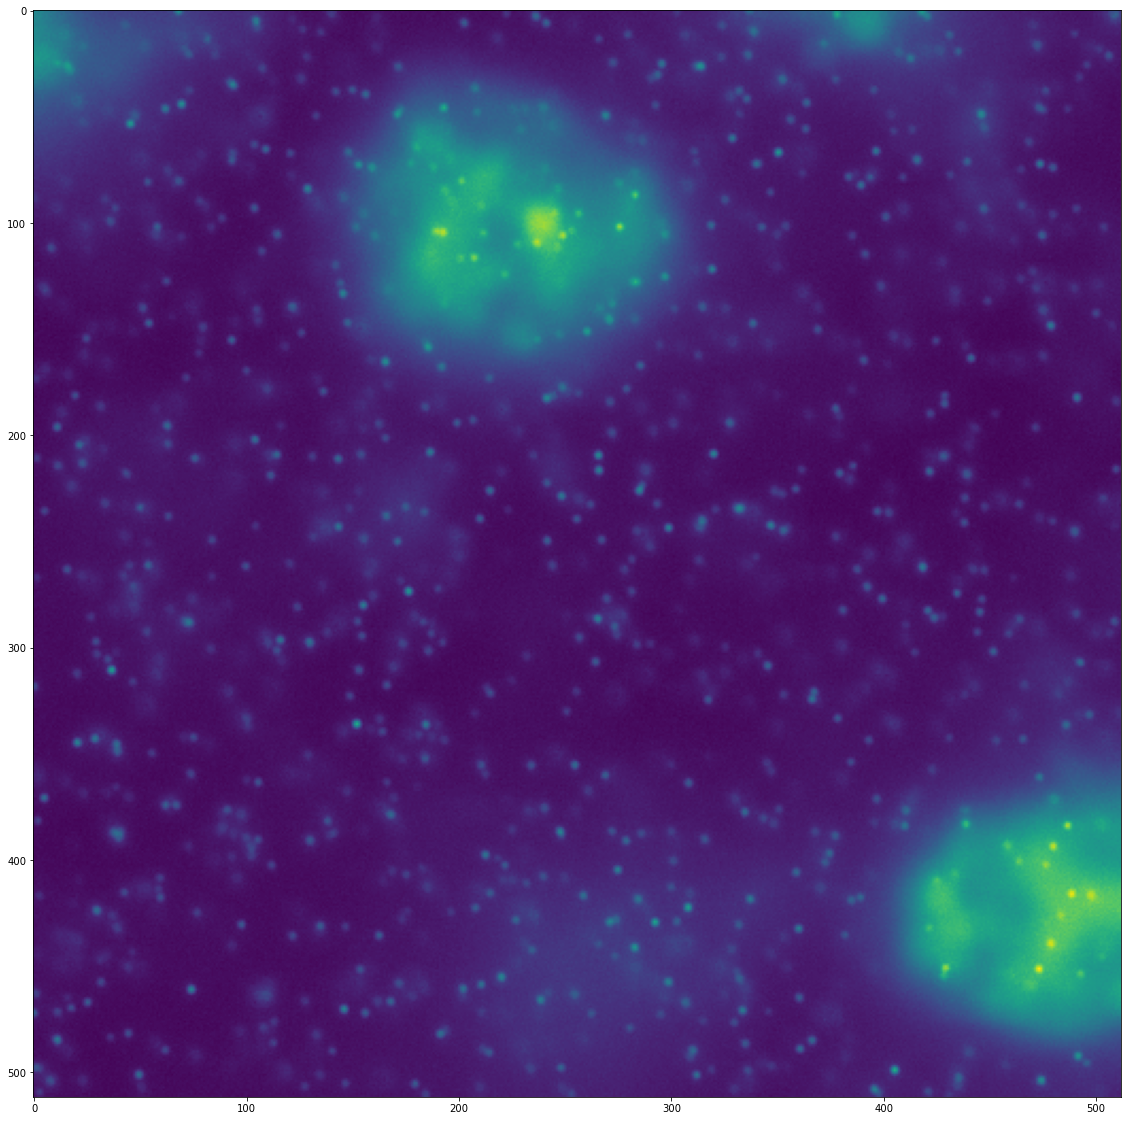

In [31]:
plt.figure(figsize=(20,20))
plt.imshow(cpu(xsim[4,13,0]))

In [32]:
with h5py.File(out_dir+'images.h5', 'w') as f:
    
    add_df_to_hdf5(f, 'locations', gt)          
    f.create_dataset('frames', data=cpu(xsim))

import tifffile
tifffile.imsave(out_dir+'images.tiff', data=cpu(xsim))

In [74]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_int_7_os/'
with h5py.File(out_dir+'images.h5', 'r') as f:
    
    gt_df = get_df_from_hdf5(f['locations'])  
    frames = f['frames'][()]

In [128]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/sl_true_gen//train.yaml')
micro_init = load_psf_noise_micro(cfg)
micro_init.load_state_dict(torch.load(cfg.data_path.micro_init+'/microscope.pkl'))

<All keys matched successfully>

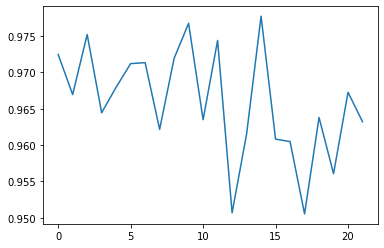

In [129]:
plt.plot(cpu(torch.load(cfg.output.save_dir+'/microscope.pkl')['channel_facs']/torch.load(cfg.data_path.micro_init+'/microscope.pkl')['channel_facs']))

In [266]:
torch.load(cfg.data_path.micro_init+'/microscope.pkl')['channel_facs']

tensor([1.2773, 1.9042, 1.3859, 1.4195, 1.8547, 1.7435, 1.6540, 1.1733, 1.4594,
        1.8244, 1.6788, 1.1114, 1.3680, 2.1615, 2.0787, 1.3688, 1.6591, 1.5163,
        1.8248, 1.9068, 1.6219, 1.5291], device='cuda:0')

In [312]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/ae_train_fixtheta//train.yaml')

In [305]:
cfg_files = glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/*/train.yaml')

In [268]:
cfg_files

['/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/ae_train_no_ch_shifts/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/ae_train_no_psf/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/sl_true_gen_no_ch_facs/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/ae_train/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/ae_train_no_ch_facs/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/sl_no_learn/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/ae_train_scf/train.yaml',
 '/groups/turaga/home/speisera/Mackebo

In [293]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [313]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_vol = cpu(micro.psf.psf_volume)
psf_init = cpu(load_tiff_image(cfg.data_path.psf_path))
post_proc.codebook = expand_codebook(torch.tensor(codebook))

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
10 volumes


0.9988866069470123
0.9882813445731689
0.984622063750422
nan


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


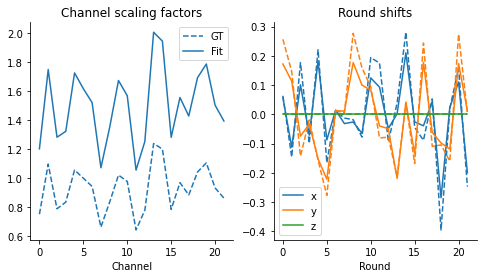

In [314]:
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8, 4))
cmap = sns.color_palette("tab10")

ax1.plot(cpu(micro_init.channel_facs), color=cmap[0], linestyle='--', label='GT')
ax1.plot(cpu(micro.channel_facs), color=cmap[0], label='Fit')
ax1.set_title('Channel scaling factors')
ax1.set_xlabel('Channel')
ax1.legend()
print(np.corrcoef(cpu(micro.channel_facs), cpu(micro_init.channel_facs))[0,1])

labels = ['x','y','z']
for i in range(3):
    ax2.plot(cpu(micro.channel_shifts[:,i]), label=labels[i], color=cmap[i])
    ax2.plot(cpu(micro_init.channel_shifts[:,i] - micro_init.channel_shifts[:,i].mean()), linestyle='--', color=cmap[i])
    print(np.corrcoef(cpu(micro.channel_shifts[:,i]), cpu(micro_init.channel_shifts[:,i]))[0,1])
ax2.set_title('Round shifts')
ax2.set_xlabel('Round')
plt.legend()
sns.despine()

In [300]:
gt_psf = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/chall_ds_psf_onesided_normed.tif')

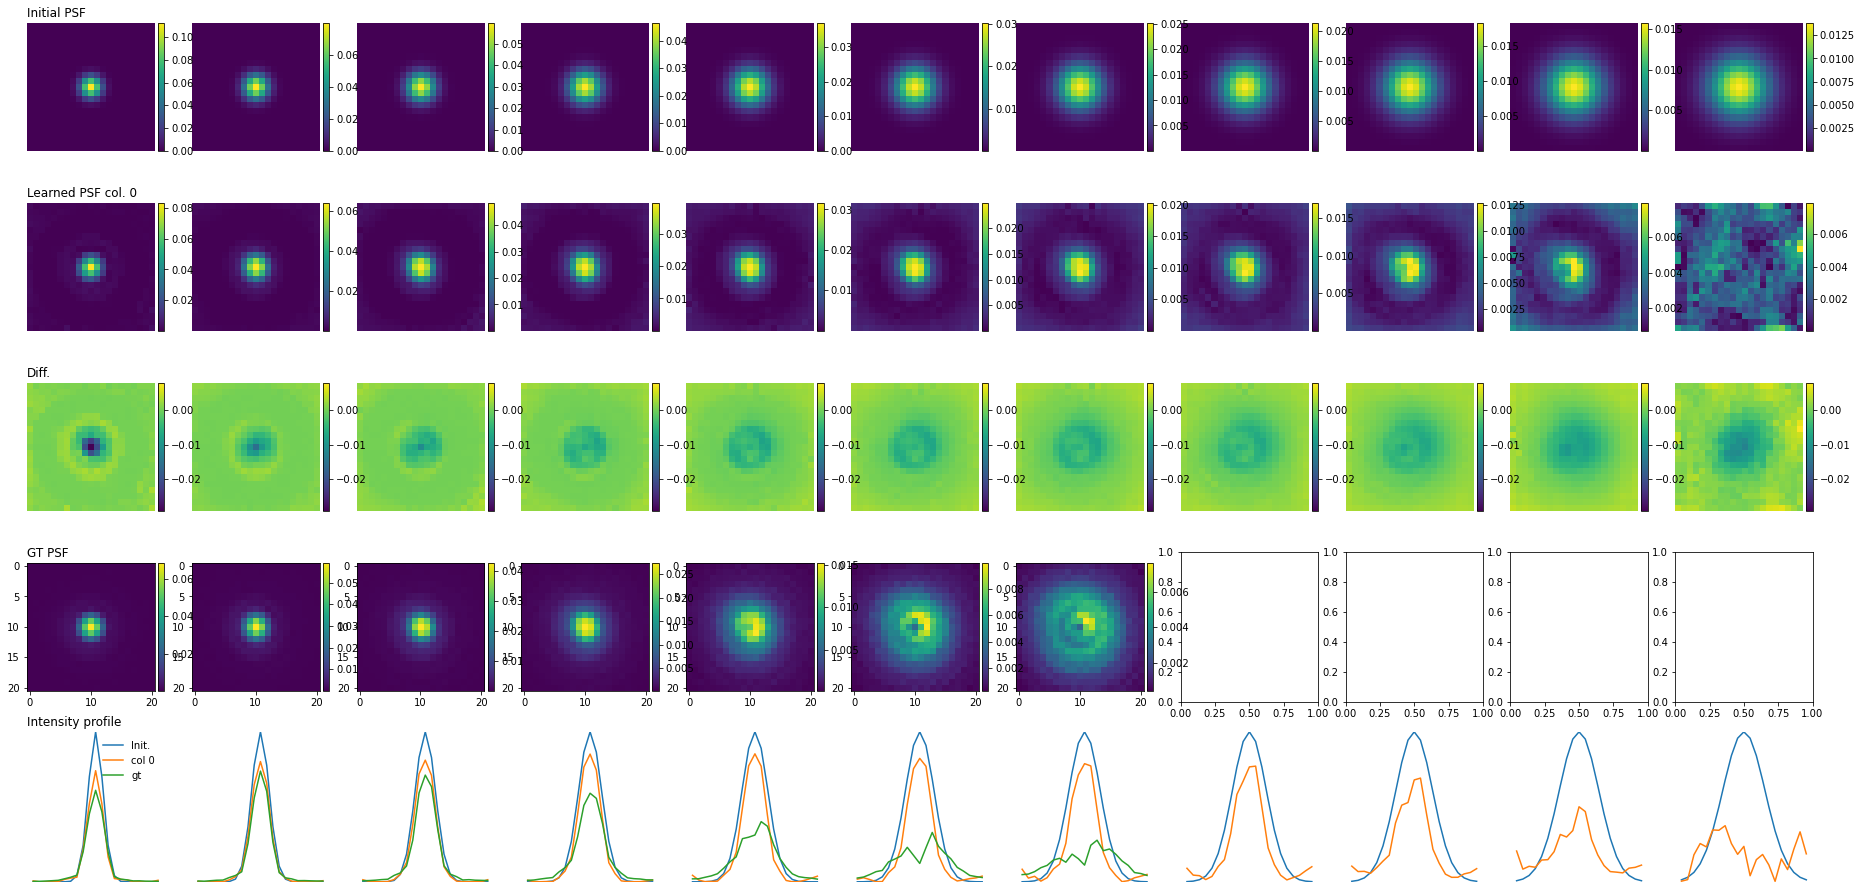

In [301]:
plot_slice_psf_pars(psf_vol, psf_init[None], cpu(gt_psf)[None], normed=True)

In [308]:
cfg_files

['/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/ae_train_no_ch_shifts/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/ae_train_no_psf/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/sl_true_gen_no_ch_facs/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/ae_train/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/ae_train_no_ch_facs/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/sl_no_learn/train.yaml',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_sim_int/sim_int_7_os2/ae_train_scf/train.yaml',
 '/groups/turaga/home/speisera/Mackebo

In [309]:
from decode_fish.funcs.predict import window_predict
df_dict = {}
for file in [cfg_files[i] for i in range(len(cfg_files))]:
    k = file.split('/')[-2]
    print(k)
#     if k not in df_dict:
    cfg = OmegaConf.load(file)
    if 'true' not in k:
        cfg.genm.PSF.psf_extent_zyx=11
    model = load_model_state(model, Path(cfg.output.save_dir)/'model.pkl').cuda()
    micro = load_psf_noise_micro(cfg)
    
    micro.load_state_dict(torch.load(Path(cfg.output.save_dir)/'microscope.pkl'), strict=False)
    res_df = window_predict(model, post_proc, torch.tensor(frames), window_size=[None, 128, 128], device='cuda', chrom_map=None, scale=micro.get_ch_mult(), progress_bar=True)
    res_df = exclude_borders(res_df, border_size_zyx=[0,500,500], img_size=[512*100,512*100,512*100])  
    df_dict[k] = res_df

ae_train_no_ch_shifts
torch.Size([10, 22, 1, 512, 512])


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.91s/it]
/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


ae_train_no_psf
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.77s/it]


sl_true_gen_no_ch_facs
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.79s/it]


ae_train
torch.Size([10, 22, 1, 512, 512])


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:38<00:00,  3.87s/it]
/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


ae_train_no_ch_facs
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.97s/it]
/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


sl_no_learn
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.95s/it]
/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


ae_train_scf
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.08s/it]


sl_true_gen
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.04s/it]
/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


ae_train_l1fix
torch.Size([10, 22, 1, 512, 512])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:41<00:00,  4.19s/it]


In [310]:
for k in df_dict.keys():
    print(k, len(df_dict[k]))

ae_train_no_ch_shifts 78763
ae_train_no_psf 72939
sl_true_gen_no_ch_facs 83074
ae_train 78741
ae_train_no_ch_facs 76454
sl_no_learn 71130
ae_train_scf 79649
sl_true_gen 82776
ae_train_l1fix 82131


In [311]:
perf_df = pd.DataFrame()
match_dict = {}

for k in df_dict.keys():
    print(k)
    
    gt_genes = gt_df[gt_df['code_inds']<len(codebook)]
    df_dict[k] = df_dict[k][df_dict[k]['code_inds']<len(codebook)]
    
    perf, matches, _ = matching(gt_df, df_dict[k], print_res=True, tolerance=500, ignore_z=True)
    df_dict[k].loc[:, 'class'] = 1
    df_dict[k].loc[df_dict[k]['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0    
    
    perf_df[k] = pd.Series(perf)
    match_dict[k] = matches

ae_train_no_ch_shifts
Recall: 0.562
Precision: 0.910
Jaccard: 53.243
RMSE_vol: 49.746
Eff_3d: 47.039
FN: 49160.0 FP: 6230.0
Num. matches: 63073.000
Shift: -24.20,11.98,21.14
ae_train_no_psf
Recall: 0.546
Precision: 0.949
Jaccard: 53.019
RMSE_vol: 51.950
Eff_3d: 46.316
FN: 50999.0 FP: 3262.0
Num. matches: 61234.000
Shift: -23.44,8.24,37.73
sl_true_gen_no_ch_facs
Recall: 0.606
Precision: 0.922
Jaccard: 57.630
RMSE_vol: 26.127
Eff_3d: 55.662
FN: 44250.0 FP: 5731.0
Num. matches: 67983.000
Shift: -0.61,0.49,0.12
ae_train
Recall: 0.565
Precision: 0.913
Jaccard: 53.653
RMSE_vol: 52.957
Eff_3d: 46.622
FN: 48781.0 FP: 6031.0
Num. matches: 63452.000
Shift: -28.32,10.58,22.86
ae_train_no_ch_facs
Recall: 0.548
Precision: 0.919
Jaccard: 52.298
RMSE_vol: 51.015
Eff_3d: 45.907
FN: 50692.0 FP: 5440.0
Num. matches: 61541.000
Shift: -26.15,10.51,12.64
sl_no_learn
Recall: 0.535
Precision: 0.958
Jaccard: 52.254
RMSE_vol: 53.009
Eff_3d: 45.391
FN: 52204.0 FP: 2646.0
Num. matches: 60029.000
Shift: -23.80,8.

/tmp/ipykernel_41679/2262223275.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dict[k].loc[:, 'class'] = 1


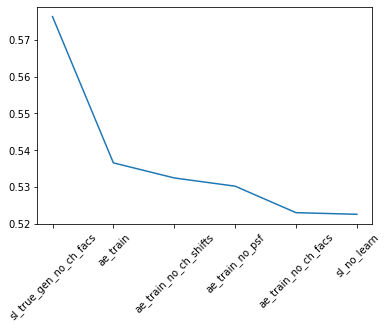

In [165]:
jacs = []
keys =['sl_true_gen_no_ch_facs', 'ae_train', 'ae_train_no_ch_shifts', 'ae_train_no_psf', 'ae_train_no_ch_facs', 'sl_no_learn']
for k in keys:
    jacs.append(perf_df[k]['jaccard'])
    
plt.plot(keys, jacs)
_ = plt.xticks(rotation=45)

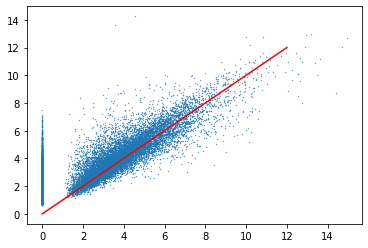

In [303]:
plt.scatter(match_dict['ae_train_no_ch_facs']['int_0_tar'], match_dict['ae_train_no_ch_facs']['int_0_pred'], s=0.1)
plt.plot([0,12],[0,12],c='red')

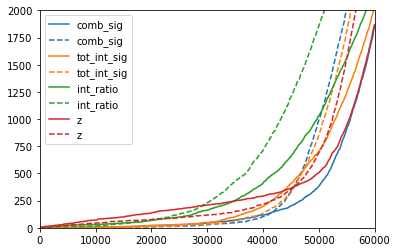

In [291]:
colmap = sns.color_palette()

df_ae = sel_int_ch(df_dict['sl_no_learn'], codebook)
df_sl = sel_int_ch(df_dict['ae_train_no_ch_facs'], codebook)

for i,k in enumerate(['comb_sig','tot_int_sig', 'int_ratio', 'z']):
# for i,k in enumerate(['comb_sig', 'int_ratio']):
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(df_ae, k, ascending=b)
    plt.plot(r, label=k, c=colmap[i])
    
    r  = make_roc(df_sl, k, ascending=b)
    plt.plot(r, label=k, linestyle='--', c=colmap[i])
    
plt.xlim(0,60000)
plt.ylim(0,2000)
plt.legend()
plt.show()

In [289]:
df_dict['sl_no_learn'].nsmallest(40000,'comb_sig')['class'].sum()
df_dict['sl_true_gen_no_ch_facs'].nsmallest(40000,'comb_sig')['class'].sum()

261

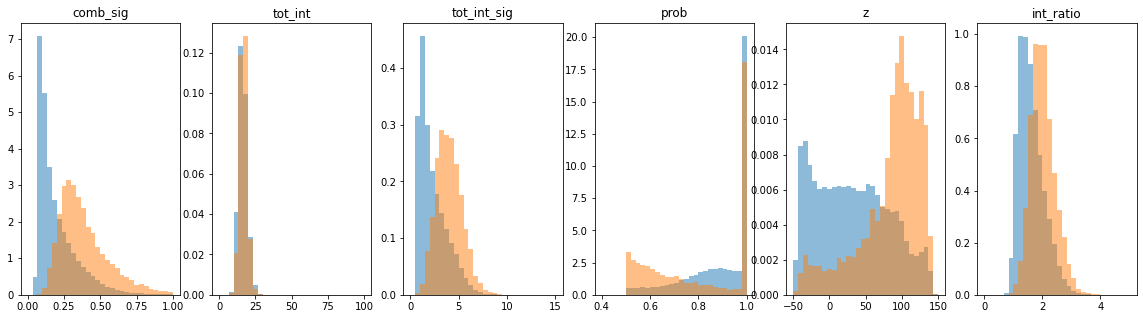

In [185]:
cdf = sel_int_ch(df_dict['sl_true_gen_no_ch_facs'], codebook)

metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio']
bins = [np.linspace(0,1.,31), np.linspace(0,100,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,5., 31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(cdf[cdf['class'] == 0][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(cdf[cdf['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

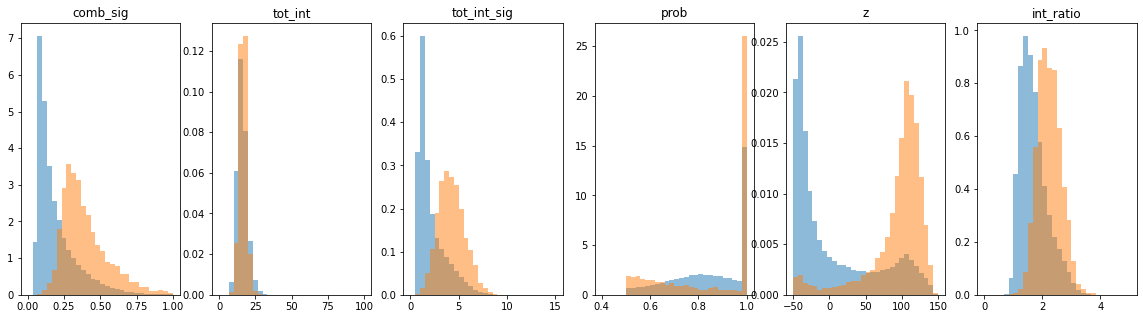

In [186]:
cdf = sel_int_ch(df_dict['ae_train'], codebook)

metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio']
bins = [np.linspace(0,1.,31), np.linspace(0,100,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,5., 31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(cdf[cdf['class'] == 0][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(cdf[cdf['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

In [53]:
# from decode_fish.funcs.routines import *
from decode_fish.funcs.routines import *
xsim, cols, gt = sim_data(decode_dl, micro, 5, 
                          int_conc=model.int_dist.int_conc.detach(), int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(),
                          channels=22, n_bits=4, codebook=torch.tensor(codebook), rate_fac=1., 
                          pos_noise_xy=cfg.genm.pos_noise.pos_noise_xy, pos_noise_z=cfg.genm.pos_noise.pos_noise_z, 
                          emitter_noise_rate_fac=cfg.genm.emitter_noise.rate_fac, emitter_noise_int_fac=cfg.genm.emitter_noise.int_fac
                         )

In [54]:
pred_dfs = []
net_inp = torch.concat([xsim], 1)
for i in range(len(net_inp)):
    pred_df = get_prediction(model, net_inp[i:i+1], post_proc, cuda=True)
    pred_dfs.append(pred_df)

pred_df = cat_emitter_dfs(pred_dfs)

In [55]:
perf, matches, _ = matching(px_to_nm(gt, cfg.evaluation.px_size_zyx), pred_df, tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)

Recall: 0.402
Precision: 0.903
Jaccard: 38.582
RMSE_vol: 63.369
Eff_3d: 30.891
FN: 3281.0 FP: 237.0
Num. matches: 2210.000
Shift: 0.80,0.19,-1.13


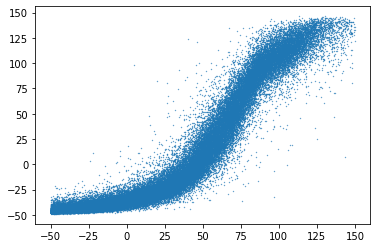

In [182]:
plt.scatter(match_dict['ae_train']['z_tar'], match_dict['ae_train']['z_pred'], s=0.1)

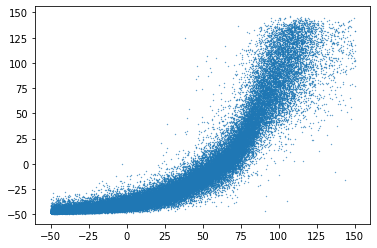

In [183]:
plt.scatter(match_dict['sl_no_learn']['z_tar'], match_dict['sl_no_learn']['z_pred'], s=0.1)

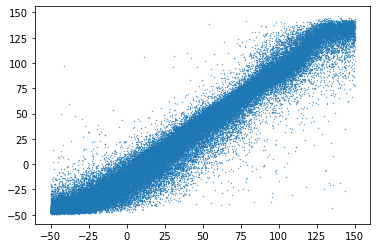

In [274]:
plt.scatter(match_dict['sl_true_gen']['z_tar'], match_dict['sl_true_gen']['z_pred'], s=0.1)

NameError: name 'res_single' is not defined

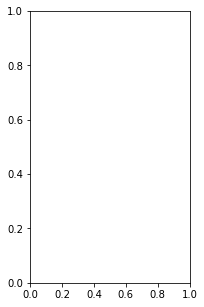

In [184]:
# res_single = sel_int_ch(res_single, codebook)
metrics = ['comb_sig','tot_int','tot_int_sig', 'prob','z', 'int_ratio']
bins = [np.linspace(0,1.5,31), np.linspace(0,30,31), np.linspace(0,15,31), np.linspace(0.4,1,31), np.linspace(-50,150.,31),  np.linspace(0.,3., 31)]
plt.figure(figsize=(20,5))
for i in range(len(metrics)):
    plt.subplot(1,len(metrics),i+1)
    _=plt.hist(res_single[~res_single['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='gene matches')
    _=plt.hist(res_single[res_single['class'] == 1][metrics[i]], density=True, alpha=0.5, bins=bins[i], label='blank matches')
    plt.title(metrics[i])

(array([5432., 5244., 4836., 4115., 3450., 2824., 2030., 1247.,  145.,
           9.]),
 array([-49.99455261, -30.79353333, -11.59251404,   7.60850525,
         26.80952454,  46.01054382,  65.21156311,  84.4125824 ,
        103.61360168, 122.81462097, 142.01564026]),
 <BarContainer object of 10 artists>)

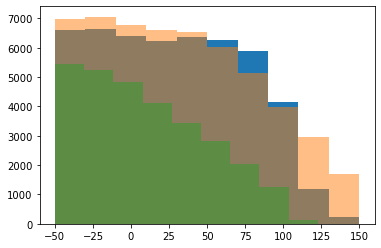

In [495]:
plt.hist(match_dict['ae_train_mae']['z_tar'])
plt.hist(match_dict['sl_true_gen_mae']['z_tar'],alpha=0.5)
plt.hist(match_dict['sl_no_learn']['z_tar'],alpha=0.5)

In [577]:
perf, matches, _ = matching(df_dict['ae_train_l1'], df_dict['sl_true_gen_mae'], print_res=True, tolerance=500, ignore_z=True)

Recall: 0.796
Precision: 0.848
Jaccard: 69.696
RMSE_vol: 51.201
Eff_3d: 60.330
FN: 12160.0 FP: 8524.0
Num. matches: 47572.000
Shift: 28.43,-11.02,-26.02


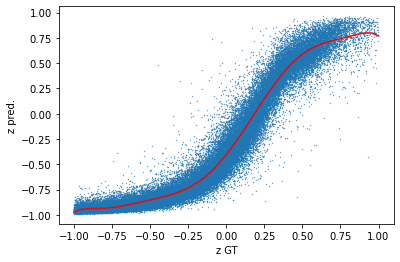

Text(0.5, 0, 'z GT')

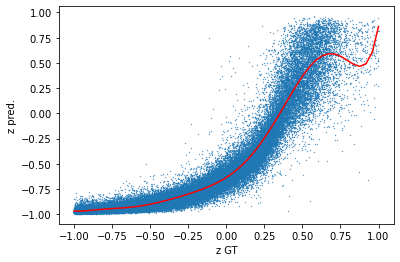

In [247]:
# get x and y vectors
x = (match_dict['ae_train']['z_tar'].values - 50)/100
y = (match_dict['ae_train']['z_pred'].values - 50)/100

# calculate polynomial
z = np.polyfit(x, y, 8)
f_l = np.poly1d(z)

# calculate new x's and y's
x_new = np.linspace(-1, 1., 50)
y_new = f_l(x_new)

plt.scatter(x, y, s=0.1)
plt.plot(x_new, y_new, color='red')
plt.ylabel('z pred.')
plt.xlabel('z GT')

plt.show()

x = (match_dict['sl_no_learn']['z_tar'].values - 50)/100
y = (match_dict['sl_no_learn']['z_pred'].values - 50)/100

# calculate polynomial
z = np.polyfit(x, y, 8)
f_i = np.poly1d(z)
x_new = np.linspace(-1, 1., 50)
y_new = f_i(x_new)

plt.scatter(x, y, s=0.1)
plt.plot(x_new, y_new, color='red')
plt.ylabel('z pred.')
plt.xlabel('z GT')

In [248]:
from decode_fish.engine.psf import LinearInterpolatedPSF

psf_gt = LinearInterpolatedPSF(gt_psf, n_cols=1, mode='bicubic').cuda()
psf_l = LinearInterpolatedPSF(psf_vol, n_cols=1, mode='bicubic').cuda()
psf_ini = LinearInterpolatedPSF(psf_init, n_cols=1, mode='bicubic').cuda()

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


In [249]:
zgt = torch.linspace(-1, 1., 100)
zgts = torch.clamp(0.5*zgt,-0.49999,0.49999) + 0.5 # transform to [0,1]
z_scaled = zgts * (7 - 2) # [0, z_size]
z_inds = (torch.div(z_scaled, 1, rounding_mode='trunc')).type(torch.cuda.LongTensor) + 1
z_os = -(z_scaled%1.) + 0.5
z_os = z_os.cuda()
z_inds = z_inds.cuda()

In [250]:
gt_stack = psf_gt.forward(z_os*0, z_os*0, z_os, z_inds.cuda(), None)
gt_stack /= gt_stack.sum(dim=[3,4], keepdim=True)

In [257]:
# zl = torch.linspace(-1, 1, 100)
zl = torch.tensor(f_l(zgt))
zls = torch.clamp(0.5*zl,-0.49999,0.49999) + 0.5 # transform to [0,1]
z_scaled = zls * (11 - 2) # [0, z_size]
z_inds = (torch.div(z_scaled, 1, rounding_mode='trunc')).type(torch.cuda.LongTensor) + 1
z_os = -(z_scaled%1.) + 0.5
z_os = z_os.cuda()
z_inds = z_inds.cuda()

l_stack = psf_l.forward(z_os*0, z_os*0, z_os, z_inds, None)
l_stack /= l_stack.sum(dim=[3,4], keepdim=True)

In [258]:
zl = torch.tensor(f_i(zgt))
zls = torch.clamp(0.5*zl,-0.49999,0.49999) + 0.5 # transform to [0,1]
z_scaled = zls * (11 - 2) # [0, z_size]
z_inds = (torch.div(z_scaled, 1, rounding_mode='trunc')).type(torch.cuda.LongTensor) + 1
z_os = -(z_scaled%1.) + 0.5
z_os = z_os.cuda()
z_inds = z_inds.cuda()

ini_stack = psf_ini.forward(z_os*0, z_os*0, z_os, z_inds, None)
ini_stack /= ini_stack.sum(dim=[3,4], keepdim=True)

In [259]:
def plot_slice_psf_pars(psf_vol, psf_init, gt_psf=None, normed=False, figsize=[32,16]):
    
    psf_vol = np.array(abs(cpu(psf_vol)))
    psf_init = np.array(abs(cpu(psf_init)))
    gt_psf = np.array(abs(cpu(gt_psf)))
    
    n_cols = len(psf_vol)
    
    if normed:
        psf_vol /= psf_vol.sum(-1).sum(-1)[...,None,None]
        psf_init /= psf_init.sum(-1).sum(-1)[...,None,None]
    
    psf_diff = psf_vol - psf_init
    n_sl = psf_init.shape[1]
    mid_px = psf_init.shape[-1]//2

    f, axes = plt.subplots(2 + 2 * n_cols + (1 if gt_psf is not None else 0), n_sl, sharey=False, figsize=figsize)
    
    for z in range(n_sl):

        vmax_z = psf_vol[0:,z].max()
        im = axes[0,z].imshow(psf_init[0,z], vmax=None)
        add_colorbar(im)
        axes[0,z].set_axis_off()
        axes[0,z].margins(x=0, y=0, tight=True)

        mlist = [psf_init[:,z].max().item(), psf_vol[:,z].max().item()]
        plt_lim = np.max(mlist)
        
        axes[-1, z].plot(psf_init[0,z,mid_px], label='Init.')
        axes[-1, z].set_axis_off()
        axes[-1, z].set_ylim(0,plt_lim)

        for n in range(n_cols):

            im = axes[1+2*n,z].imshow(psf_vol[n,z], vmax=None)
            add_colorbar(im)
            axes[1+2*n,z].set_axis_off()
            axes[1+2*n,z].margins(x=0, y=0, tight=True)

            im = axes[2+2*n,z].imshow(psf_diff[n,z], vmax=psf_diff.max(), vmin=psf_diff.min())
            add_colorbar(im)
            axes[2+2*n,z].set_axis_off()
            axes[2+2*n,z].margins(x=0, y=0, tight=True)

            axes[-1, z].plot(psf_vol[n,z,mid_px], label=f'col {n}')
            
        if gt_psf is not None:
            
            if z < len(gt_psf[0]):
                im = axes[-2, z].imshow(gt_psf[n,z], vmax=None)
                add_colorbar(im)
                axes[-1, z].plot(gt_psf[n,z,mid_px], label='gt')

    axes[-1, 0].legend(frameon=False)
    axes[0,0].set_title('Initial PSF', loc='left')
    axes[-1,0].set_title(f'Intensity profile', loc='left')
    
    for n in range(n_cols):
        axes[1+2*n,0].set_title(f'Learned PSF col. {n}', loc='left')
        axes[2+2*n,0].set_title(f'Diff.', loc='left')
        
    if gt_psf is not None:
        axes[-2,0].set_title('GT PSF', loc='left')

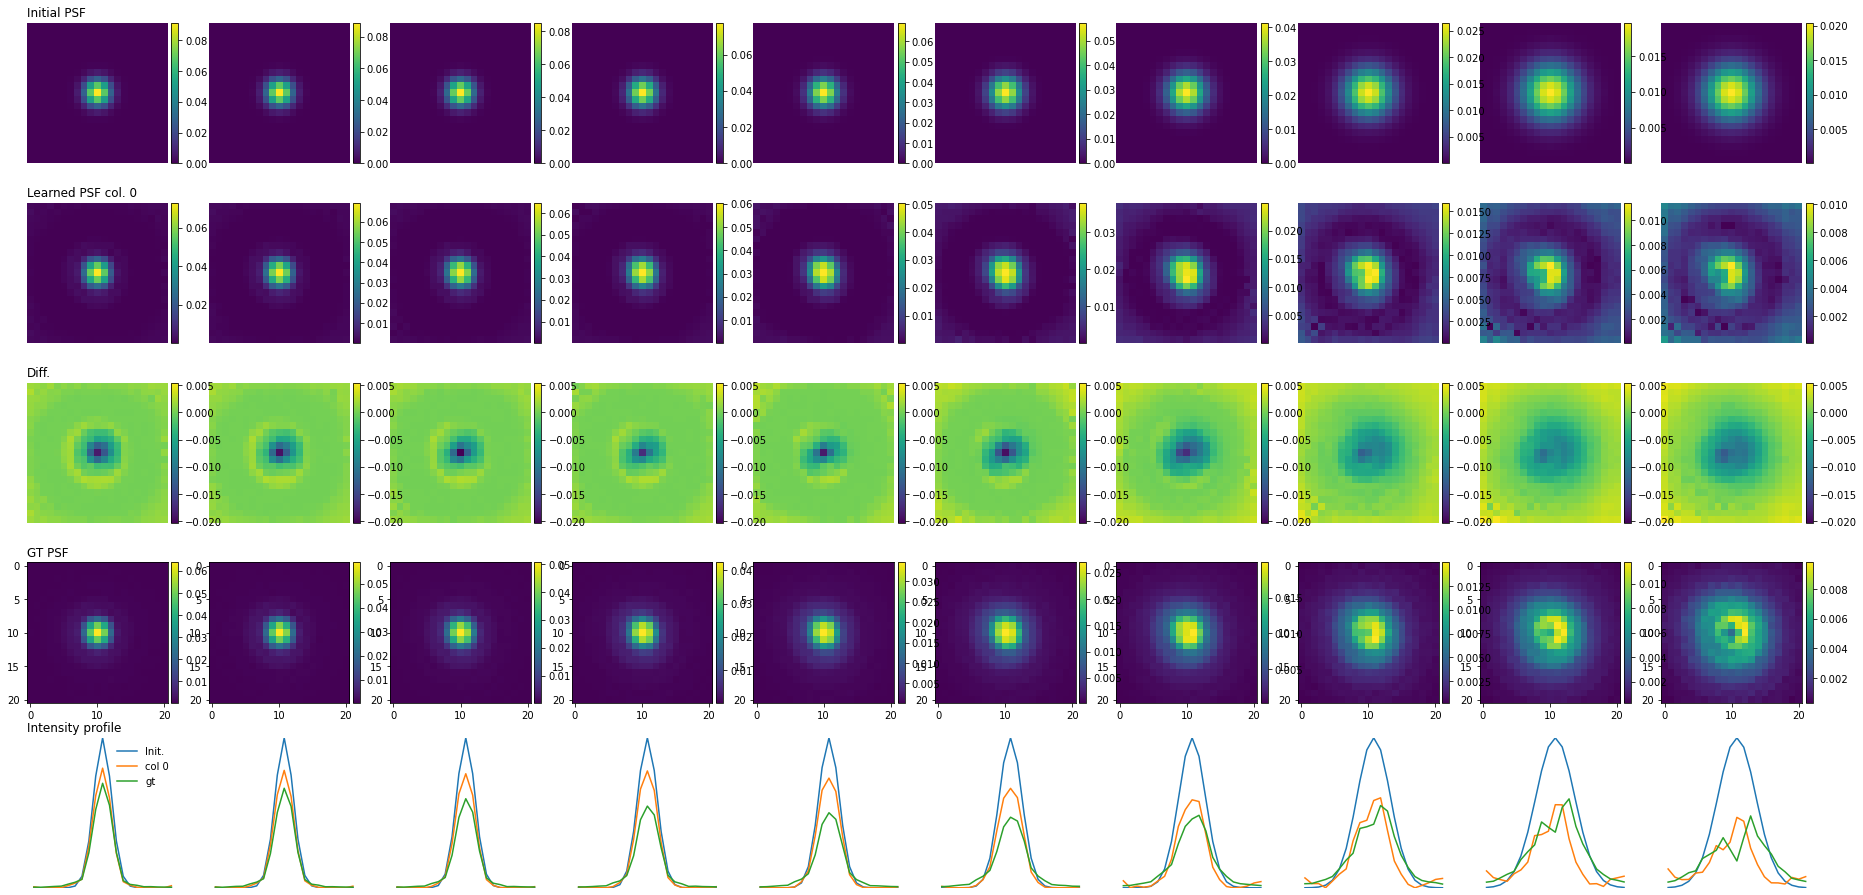

In [260]:
plot_slice_psf_pars(l_stack[::10,0,0][None], ini_stack[::10,0,0][None], gt_stack[::10,0,0][None], normed=True)

In [90]:
micro.psf_init_vol.shape

torch.Size([1, 11, 21, 21])